<a href="https://colab.research.google.com/github/gordicaleksa/get-started-with-JAX/blob/main/Tutorial_3_JAX_Neural_Network_from_Scratch_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training 2 Hidden Layer NN on MNIST

In [44]:
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [45]:
!pip install partial

JAX is NumPy on the CPU, GPU, and TPU, with great automatic differentiation for high-performance machine learning research.

**WEIGHTS INITIALIZTION:-**

jax.random.PRNGKey(seed) :- Creates a pseudo-random number generator (PRNG) key given an integer seed.

jax.random.split(key, num) :- Splits a PRNG key into num new keys by adding a leading axis.

jax.random.normal(key, shape=(), dtype=<class 'numpy.float64'>) :- Sample standard normal random values with given shape and float dtype.


In [46]:
seed = 0
mnist_img_size = (28, 28)

#The init_MLP function initializes weights given layer_widths, parent_key, scale.
#layer_widths specifies the number of layers as well as number of neurons in each layer.
#scale is used to scale weigths.
def init_MLP(layer_widths, parent_key, scale=0.01):

    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )

    return params

#testing if init_MLP working fine.
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], key)
print(jax.tree_map(lambda x: x.shape, MLP_params))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


jax.nn.relu(x) :- Rectified linear unit activation function.

jax.numpy.dot(a, b, *, precision=None) :- Dot product of two arrays.

vmap(fun[, in_axes, out_axes, axis_name, ...]) :- Vectorizing map

In [47]:
def MLP_predict(params, x):
    hidden_layers = params[:-1]
    #Forward propagation
    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    return logits - logsumexp(logits)#The returned value is basically like a softmax. Refer the comments below.
                                     # log(exp(o1)) - log(sum(exp(o1), exp(o2), ..., exp(o10)))
                                     # log( exp(o1) / sum(...) )


batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

jax.numpy.ravel(a, order='C') :- Return a contiguous flattened array.

jax.numpy.stack(arrays, axis=0, out=None) :- Join a sequence of arrays along a new axis.

In [48]:
def custom_transform(x):
    return jnp.ravel(jnp.array(x, dtype=jnp.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = jnp.array(transposed_data[1])
    imgs = jnp.stack(transposed_data[0])

    return imgs, labels

batch_size = 128 #batch size of each minibatch is 128. The batch size of the last minibatch is not always 128 because the dataset might not be divisible by 128
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform) #obtaining the train dataset
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform) #obtaining the test dataset

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True) #loading the train data into train loader
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True) #loading the test data into test loader

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)


In [49]:
print(train_lbls.shape) # depicts the number of training labels
print(test_lbls.shape) # depicts the number of test labels

(60000,)
(10000,)


##### Pytrees :- a pytree is a container of leaf elements and/or more pytrees. Containers include lists, tuples, and dicts. A leaf element is anything that’s not a pytree, e.g. an array. In other words, a pytree is just a possibly-nested standard or user-registered Python container. If nested, note that the container types do not need to match. A single “leaf”, i.e. a non-container object, is also considered a pytree.

pytrees was used while updating the parameters in the cell below.


In [50]:
from torch.utils import data
num_epochs = 7  # The number of epochs we are taking are 7.

def loss_fn(params, imgs, gt_lbls):
    predictions = batched_MLP_predict(params, imgs)

    return -jnp.mean(predictions * gt_lbls)

#The below function accuracy computes accuracy.
def accuracy(params, dataset_imgs, dataset_lbls):
  pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    
  return jnp.mean(dataset_lbls == pred_classes)
  

@jit
#The below function update() updates the parameters.
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls) #Computing Gradients.

    return loss, jax.tree_multimap(lambda p, g: p - lr*g, params, grads)

# Creating a MLP
import numpy as np
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key) #weigth initialization.
loss_lst = []
itr_lst = []
itr = 1

#training for 7 epochs
for epoch in range(num_epochs):

    for cnt, (imgs, lbls) in enumerate(train_loader):

        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
        
        loss, MLP_params = update(MLP_params, imgs, gt_labels)
        loss_lst.append(loss) #appending all the losses we obtain to the list.
        itr_lst.append(itr) #keeping track of the number of iterations which can be used while plotting.
        itr = itr+1
        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')


0.23922558
0.095801175
0.05996817
0.051604707
0.047431525
0.03413192
0.03355768
0.03721596
0.032839555
0.02978969
Epoch 0, train acc = 0.9136000275611877 test acc = 0.9170999526977539
0.025859384
0.0257133
0.023435328
0.024251645
0.03525386
0.027787108
0.025248438
0.019682182
0.026431669
0.019541552
Epoch 1, train acc = 0.930816650390625 test acc = 0.9314000010490417
0.020417746
0.024100913
0.031246787
0.022210117
0.028642481
0.021477906
0.01295908
0.018589342
0.0179221
0.010384212
Epoch 2, train acc = 0.9464833736419678 test acc = 0.9447000026702881
0.024123117
0.02416863
0.016079918
0.014930136
0.008141152
0.012924257
0.019127615
0.014852071
0.023567175
0.013074306
Epoch 3, train acc = 0.9537667036056519 test acc = 0.9501999616622925
0.014135728
0.011374704
0.019640002
0.017512143
0.020527873
0.022658706
0.016445726
0.014815795
0.019759249
0.011246353
Epoch 4, train acc = 0.9609833359718323 test acc = 0.9549999833106995
0.008794077
0.01524237
0.013802004
0.019118225
0.012855179
0.018

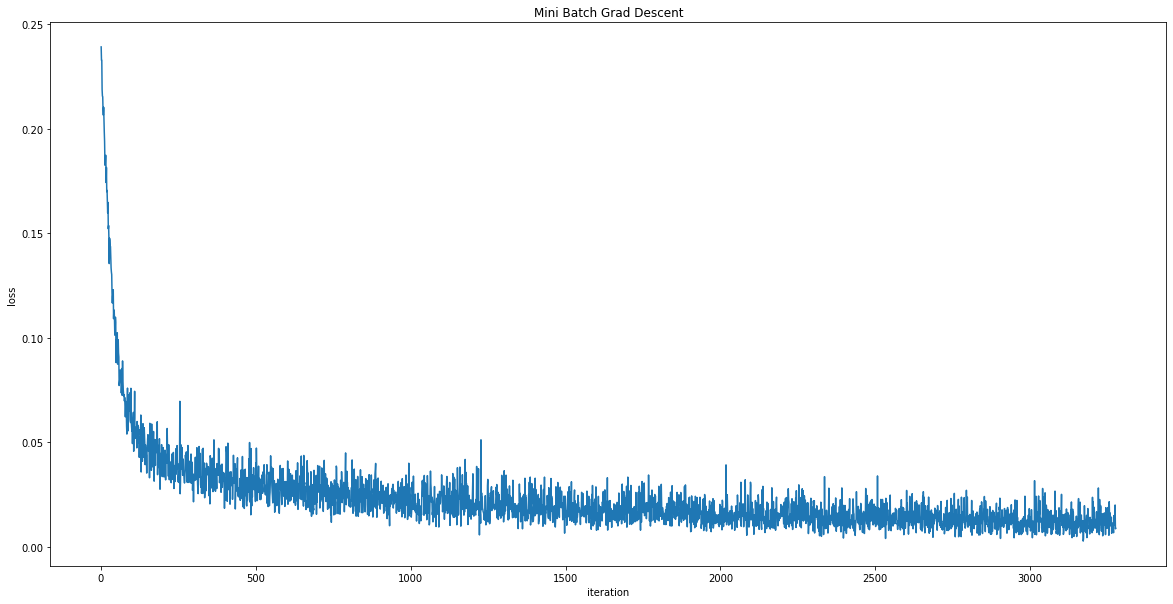

In [51]:
plt.figure(figsize=(20,10))
plt.plot(itr_lst,loss_lst)
plt.xlabel('iteration')
plt.ylabel('loss')

plt.title('Mini Batch Grad Descent')
plt.show()

The Noise in the above plot is because we used mini-batch gradient descent.

In [52]:
from sklearn.metrics import classification_report
pred_classes = jnp.argmax(batched_MLP_predict(MLP_params, test_images), axis=1)
print(classification_report(test_lbls, pred_classes))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.94      0.98      0.96      1010
           4       0.97      0.96      0.96       982
           5       0.96      0.95      0.95       892
           6       0.96      0.97      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.95      0.94      0.95       974
           9       0.96      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



ACCURACY :-
Accuracy is the quintessential classification metric. It is pretty easy to understand. And easily suited for binary as well as a multiclass classification problem. Accuracy is the proportion of true results among the total number of cases examined.

Since test accuracy is very high. We can imply that the model is Generalizing well for new examples and also that the propotion of examples that are classified correctly among the total number of cases is high. Therefore, the model is doing a good job.

PRECISION :- High precision implies that high proportion of predicted Positives are truly Positive.

RECALL :- High recall implies that high proportion of actual Positives are correctly classified.

F1 SCORE :- The F1 score is a number between 0 and 1 and is the harmonic mean of precision and recall. This metric is Generally used when we want our model to have both good precision and recall. Simply stated the F1 score sort of maintains a balance between the precision and recall for your classifier. If the precision is low, the F1 is low and if the recall is low again the F1 score is low. High F1 score is always desirable